# Agentic Framework in Llama Index

## Tool Use

The FunctionTool module can be used here to convert any function into a tool that the agent could call if it feels the necessity



In [1]:
import requests
from llama_index.core.tools import FunctionTool
from llama_index.llms.openai import OpenAI
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Declare API_KEY and OPENAI_API_KEY.

### 1. To access external API data 

In [3]:
def get_weather(city_name, units='imperial'):
    """
    Function that taken in a city name and units and returns the temperature and description of weather

    Args:
    city_name: The name of the city (ex: Los Angeles)
    units: The measurement units for tempreature (Options: imperial - fahreinheit, metric - celsius), Default: fahrenheit (imperial)

    Return:
    city: Name of the City
    temperature: the temperature in the provided measurement units
    description: the short description of the weather
    """
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    complete_url = base_url + "appid=" + API_KEY + "&q=" + city_name + "&units=" + units
    
    response = requests.get(complete_url)
    
    if response.status_code == 200:
        weather_data = response.json()
        return {
            'city': city_name,
            'temperature': weather_data['main']['temp'],
            'description': weather_data['weather'][0]['description']
        }
    else:
        return {'error': 'Failed to retrieve weather data', 'status_code': response.status_code}

In [4]:
# Declare tool
weather_fetch_tool = FunctionTool.from_defaults(fn=get_weather)

#### Instance of simple function call using the OpenAI LLM

In [5]:
# Use query engine with the tool

llm = OpenAI(model="gpt-3.5-turbo", api_key=OPENAI_API_KEY)
response = llm.predict_and_call(
    [weather_fetch_tool], 
    "How is the weather in San Jose right now?", 
    verbose=True
)
print(str(response))

=== Calling Function ===
Calling function: get_weather with args: {"city_name": "San Jose"}
=== Function Output ===
{'city': 'San Jose', 'temperature': 72.91, 'description': 'broken clouds'}
{'city': 'San Jose', 'temperature': 72.91, 'description': 'broken clouds'}


#### Using the agent

### Combination of Runner and Worker

Runner - Manages/Orchestrates the different tasks once the query is received, oversees the outputs of the worker, returns final response when ready

Worker - Does the actual execution of the individual tasks using the available tools

![components](/Users/chandrasekaransidha/personal/sandbox/img/agent_components.png)

In [10]:
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

agent_worker = FunctionCallingAgentWorker.from_tools(
    [weather_fetch_tool], 
    llm=llm, 
    verbose=True
)
agent = AgentRunner(agent_worker)


In [11]:
response = agent.query("Who is Connor McGregor?")

Added user message to memory: Who is Connor McGregor?
=== LLM Response ===
Conor McGregor is a professional mixed martial artist and former UFC (Ultimate Fighting Championship) featherweight and lightweight champion. He is known for his charismatic personality, trash-talking, and fighting skills inside the octagon. McGregor is one of the most popular and successful fighters in the history of MMA (Mixed Martial Arts).


In [12]:
response = agent.query("What is the weather in Hayward right now?")

Added user message to memory: What is the weather in Hayward right now?
=== Calling Function ===
Calling function: get_weather with args: {"city_name": "Hayward"}
=== Function Output ===
{'city': 'Hayward', 'temperature': 66.83, 'description': 'clear sky'}
=== LLM Response ===
The weather in Hayward right now is clear sky with a temperature of 66.83°F.


### 2. Auto Retrieval: To perform metadata filtering while retrieving data (RAG) 

## Autogen

### Task: Executing code

Using a combination of code writer and executor to 
- Fetch the requirement from the user
- Write the code to execute the task
- Execute the code and share the results

In [1]:
llm_config = {"model": "gpt-4-turbo"}

In [3]:
from autogen.coding import LocalCommandLineCodeExecutor
from autogen import ConversableAgent, AssistantAgent

#### Instantiate the executor that gives the agent the capability to execute code

The working directory parameter would create the said directory if it doesn't exist and
this is where all the code and other files (pngs and markdowns) get stored

In [6]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

#### Define the code executor: Executes the code written by the writer

Notice that the executor initiated before is provided as a parameter

In [7]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

#### Define the code writer agent

In [4]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

#### Definining the task

In [8]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains.png."""

#### Initiate the chat, define the executor and link it with the writer and the task description

In [9]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2024-06-16. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To achieve the task of plotting stock gains Year-To-Date (YTD) for Nvidia (NVDA) and Tesla (TSLA) and saving the figure to a file, I will guide you through the following steps:

1. **Install Required Libraries**: Install `yfinance`, which is a popular library to fetch historical market data from Yahoo Finance. Also, we need `matplotlib` for plotting.
2. **Fetch Stock Data**: Using `yfinance` to download YTD stock data for NVDA and TSLA starting from 2024-01-01 to today (2024-06-16).
3. **Compute Stock Gains**: Calculate the percentage gain from the start of the year.
4. **Plot the Data**: Using `matplotlib` to plot the data.
5. **Save the Plot**: 

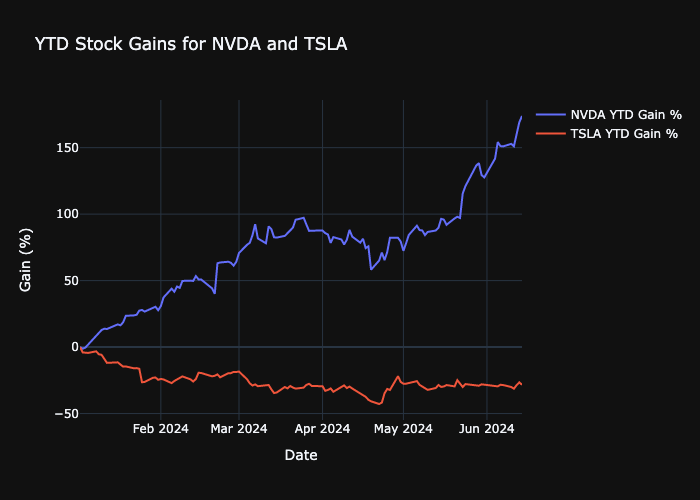

In [10]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))